## 控制社会人口学信息

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import MultiComparison
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')

# 读取数据
data = pd.read_excel('./rawdata.xlsx', sheet_name='Sheet2')

# 删除 'Cluster' 列中等于 3 的行
data_cleaned = data[data['Cluster'] != 3]

data = data_cleaned

# 将列名中的空格替换为下划线,去掉逗号
data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 定义要检测的变量
variables = [

    ("CK_baseline", "CK_followup"),
    ("TG_baseline", "TG_followup"),
    ("CHOL_baseline", "CHOL_followup"),
    ("HDLC_baseline", "HDLC_followup"),
    ("LDLC_baseline", "LDLC_followup")
]

# 添加主题列
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所有列名一致
required_columns = [
    'Cluster', 'Subject', 'Age', 
    'Education_years', 'Gender']

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(baseline_var, followup_var):
    # 确保变量名一致
    baseline_var = baseline_var.replace(' ', '_')
    followup_var = followup_var.replace(' ', '_')

    # 数据重塑为长格式
    df_long = pd.melt(data, id_vars=required_columns, 
                      value_vars=[baseline_var, followup_var], 
                      var_name='Time', value_name='Score')
    
    df_long['Time'] = df_long['Time'].map({baseline_var: 0, followup_var: 1})
    df_long['Cluster'] = df_long['Cluster'].astype('category')
    
    # 哑变量生成
    df_long = pd.get_dummies(df_long, columns=[
        'Gender'], drop_first=True)

    # 定义线性混合效应模型公式
    formula = ("Score ~ Time * Cluster + Age + "
               "Education_years + " +
               " + ".join(df_long.columns[df_long.columns.str.startswith(('Gender_'))]))
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的p值
    p_values = mdf.pvalues.loc[['Time', 'Cluster[T.1]', 'Time:Cluster[T.1]']]

    # 多重比较校正
    _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    p_values_corrected_dict = dict(zip(p_values.index, p_values_corrected))

    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'Time_pvalue': p_values.loc['Time'],
        'Cluster_pvalue': p_values.loc['Cluster[T.1]'],
        'Interaction_pvalue': p_values.loc['Time:Cluster[T.1]'],
        'Time_pvalue_corrected': p_values_corrected_dict['Time'],
        'Cluster_pvalue_corrected': p_values_corrected_dict['Cluster[T.1]'],
        'Interaction_pvalue_corrected': p_values_corrected_dict['Time:Cluster[T.1]'],
        'df_long': df_long  # Store the long format data for post-hoc analysis
    }

# 对每个变量进行分析并存储结果
for baseline_var, followup_var in variables:
    results[baseline_var] = perform_lmm_analysis(baseline_var, followup_var)

# 定义绘图函数
def plot_interaction(df_long, var_name):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    sns.lineplot(x="Time", y="Score", hue="Cluster", 
                 data=df_long, markers=True, dashes=False, 
                 ci='sd', palette="muted")

    plt.title(f'Interaction Plot for {var_name}')
    plt.xlabel('Time')
    plt.ylabel('Score')
    plt.xticks([0, 1], ['Baseline', 'Follow-up'])
    plt.legend(title='Cluster', loc='upper left')
    plt.tight_layout()
    plt.show()

# 输出结果
for var, result in results.items():
    print(f"Variable: {var}")
    print(result['LMM_summary'])
    print(f"Time p-value (corrected): {result['Time_pvalue_corrected']:.3f}")
    print(f"Cluster p-value (corrected): {result['Cluster_pvalue_corrected']:.3f}")
    print(f"Interaction p-value (corrected): {result['Interaction_pvalue_corrected']:.3f}")

    # 进行事后比较
    if result['Interaction_pvalue_corrected'] < 0.05:  # Check for significance
        mc = MultiComparison(result['df_long']['Score'], 
                             result['df_long']['Time'].astype(str) + "_" + result['df_long']['Cluster'].astype(str))
        post_hoc_results = mc.tukeyhsd(alpha=0.05)

        # 修改Tukey HSD表的显示
        summary_df = pd.DataFrame(data=post_hoc_results.summary().data[1:], columns=post_hoc_results.summary().data[0])
        summary_df['group1'] = summary_df['group1'].replace({'0_0': 'baseline_Subtype I', '0_1': 'baseline_Subtype II', 
                                                             '1_0': 'followup_Subtype I', '1_1': 'followup_Subtype II'})
        summary_df['group2'] = summary_df['group2'].replace({'0_0': 'baseline_Subtype I', '0_1': 'baseline_Subtype II', 
                                                             '1_0': 'followup_Subtype I', '1_1': 'followup_Subtype II'})
        print(tabulate(summary_df, headers='keys', tablefmt='pretty'))

        # 输出均值和标准差
        means = result['df_long'].groupby(['Time', 'Cluster'])['Score'].agg(['mean', 'std']).reset_index()
        means['Cluster'] = means['Cluster'].map({0: 'Subtype I', 1: 'Subtype II'})
        means['Time'] = means['Time'].map({0: 'baseline', 1: 'followup'})
        
        for idx, row in means.iterrows():
            print(f"Cluster: {row['Cluster']}, Time: {row['Time']}, Mean: {row['mean']:.2f}, Std: {row['std']:.2f}")
    print("---")



Variable: CK_baseline
              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    Score    
No. Observations:     172        Method:                REML     
No. Groups:           86         Scale:                 996.7131 
Min. group size:      2          Log-Likelihood:        -884.2383
Max. group size:      2          Converged:             Yes      
Mean group size:      2.0                                        
-----------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           104.197   19.664  5.299 0.000  65.655 142.738
Cluster[T.1]        -16.662   13.909 -1.198 0.231 -43.924  10.599
Time                -21.378   11.653 -1.835 0.067 -44.217   1.461
Time:Cluster[T.1]    14.885   14.844  1.003 0.316 -14.208  43.979
Age                  -0.213    0.398 -0.534 0.593  -0.992   0.567
Ed

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import MultiComparison
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')

# 读取数据
data = pd.read_excel('./rawdata.xlsx', sheet_name='Sheet2')

# 删除 'Cluster' 列中等于 3 的行
data_cleaned = data[data['Cluster'] != 3]

data = data_cleaned

# 将列名中的空格替换为下划线,去掉逗号
data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 定义要检测的变量
variables = [
    ( "WBC_baseline", "WBC_followup"),
    ("NEUT_baseline", "NEUT_followup"),
    ("LYMPH_baseline", "LYMPH_followup"),
    ("MONO_baseline", "MONO_followup"),
    ("PIL_baseline", "PIL_followup"),
    ("CRP_baseline", "CRP_followup"),
    ("NLR_baseline", "NLR_followup"),
    ("PLR_baseline", "PLR_followup"),
    ("MLR_baseline", "MLR_followup"),
    ("SIII_baseline", "SIII_followup"),
    ("ASTALT_baseline", "ASTALT_followup"),
    ("LDH_baseline", "LDH_followup"),
]

# 添加主题列
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所有列名一致
required_columns = [
    'Cluster', 'Subject',  'Age', 
    'Education_years', 'Gender']

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(baseline_var, followup_var):
    # 确保变量名一致
    baseline_var = baseline_var.replace(' ', '_')
    followup_var = followup_var.replace(' ', '_')

    # 数据重塑为长格式
    df_long = pd.melt(data, id_vars=required_columns, 
                      value_vars=[baseline_var, followup_var], 
                      var_name='Time', value_name='Score')
    
    df_long['Time'] = df_long['Time'].map({baseline_var: 0, followup_var: 1})
    df_long['Cluster'] = df_long['Cluster'].astype('category')
    
    # 哑变量生成
    df_long = pd.get_dummies(df_long, columns=[
        'Gender'], drop_first=True)

    # 定义线性混合效应模型公式
    formula = ("Score ~ Time * Cluster + Age + "
               "Education_years + " +
               " + ".join(df_long.columns[df_long.columns.str.startswith(('Gender_'))]))
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的p值
    p_values = mdf.pvalues.loc[['Time', 'Cluster[T.1]', 'Time:Cluster[T.1]']]

    # 多重比较校正
    _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    p_values_corrected_dict = dict(zip(p_values.index, p_values_corrected))

    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'Time_pvalue': p_values.loc['Time'],
        'Cluster_pvalue': p_values.loc['Cluster[T.1]'],
        'Interaction_pvalue': p_values.loc['Time:Cluster[T.1]'],
        'Time_pvalue_corrected': p_values_corrected_dict['Time'],
        'Cluster_pvalue_corrected': p_values_corrected_dict['Cluster[T.1]'],
        'Interaction_pvalue_corrected': p_values_corrected_dict['Time:Cluster[T.1]'],
        'df_long': df_long  # Store the long format data for post-hoc analysis
    }

# 对每个变量进行分析并存储结果
for baseline_var, followup_var in variables:
    results[baseline_var] = perform_lmm_analysis(baseline_var, followup_var)

# 定义绘图函数
def plot_interaction(df_long, var_name):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    sns.lineplot(x="Time", y="Score", hue="Cluster", 
                 data=df_long, markers=True, dashes=False, 
                 ci='sd', palette="muted")

    plt.title(f'Interaction Plot for {var_name}')
    plt.xlabel('Time')
    plt.ylabel('Score')
    plt.xticks([0, 1], ['Baseline', 'Follow-up'])
    plt.legend(title='Cluster', loc='upper left')
    plt.tight_layout()
    plt.show()

# 输出结果
for var, result in results.items():
    print(f"Variable: {var}")
    print(result['LMM_summary'])
    print(f"Time p-value (corrected): {result['Time_pvalue_corrected']:.3f}")
    print(f"Cluster p-value (corrected): {result['Cluster_pvalue_corrected']:.3f}")
    print(f"Interaction p-value (corrected): {result['Interaction_pvalue_corrected']:.3f}")

    # 进行事后比较
    if result['Interaction_pvalue_corrected'] < 0.06:  # Check for significance
        mc = MultiComparison(result['df_long']['Score'], 
                             result['df_long']['Time'].astype(str) + "_" + result['df_long']['Cluster'].astype(str))
        post_hoc_results = mc.tukeyhsd(alpha=0.05)

        # 修改Tukey HSD表的显示
        summary_df = pd.DataFrame(data=post_hoc_results.summary().data[1:], columns=post_hoc_results.summary().data[0])
        summary_df['group1'] = summary_df['group1'].replace({'0_0': 'baseline_Subtype I', '0_1': 'baseline_Subtype II', 
                                                             '1_0': 'followup_Subtype I', '1_1': 'followup_Subtype II'})
        summary_df['group2'] = summary_df['group2'].replace({'0_0': 'baseline_Subtype I', '0_1': 'baseline_Subtype II', 
                                                             '1_0': 'followup_Subtype I', '1_1': 'followup_Subtype II'})
        print(tabulate(summary_df, headers='keys', tablefmt='pretty'))

        # 输出均值和标准差
        means = result['df_long'].groupby(['Time', 'Cluster'])['Score'].agg(['mean', 'std']).reset_index()
        means['Cluster'] = means['Cluster'].map({0: 'Subtype I', 1: 'Subtype II'})
        means['Time'] = means['Time'].map({0: 'baseline', 1: 'followup'})
        
        for idx, row in means.iterrows():
            print(f"Cluster: {row['Cluster']}, Time: {row['Time']}, Mean: {row['mean']:.2f}, Std: {row['std']:.2f}")
    print("---")


Variable: WBC_baseline
           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Score    
No. Observations:    172      Method:              REML     
No. Groups:          86       Scale:               0.9226   
Min. group size:     2        Log-Likelihood:      -314.4922
Max. group size:     2        Converged:           Yes      
Mean group size:     2.0                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          6.194    0.748  8.279 0.000  4.728  7.661
Cluster[T.1]      -0.312    0.343 -0.908 0.364 -0.984  0.361
Time               0.490    0.276  1.773 0.076 -0.052  1.032
Time:Cluster[T.1]  0.098    0.352  0.278 0.781 -0.592  0.788
Age                0.011    0.017  0.622 0.534 -0.023  0.044
Education_years   -0.050    0.039 -1.287 0.198 -0.127  0.026
Gender_2     

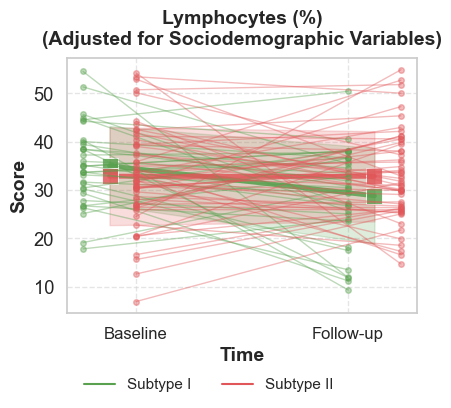

In [3]:
def plot_interaction(df_long, var_name):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # 设置整体风格，确保图表清晰且专业，增强图表对比度
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(4.5,4.5))  # 提高分辨率以满足高水平出版要求
    
    # 将群组标签映射到新的名称
    df_long['Cluster'] = df_long['Cluster'].map({0: 'Subtype I', 1: 'Subtype II'})
    
    # 使用具有色盲友好特性的调色板
    palette = {
        "Subtype I": "#59A14F",  # Green
        "Subtype II": "#E15759",  # Red
}
    # 绘制带误差条的交互作用图，并调整透明度以突出关键趋势线
    sns.lineplot(x="Time", y="Score", hue="Cluster", 
                 data=df_long, markers=True, dashes=False, 
                 ci='sd', palette=palette, 
                 marker='s', linewidth=3.5, alpha=0.85, markersize=12)
    
    # 为每个亚组设置不同的颜色，并在X轴上错开显示
    offset = {'Subtype I': -0.1, 'Subtype II': 0.1}  # 设置X轴偏移量
    for cluster, color in zip(['Subtype I', 'Subtype II'], ["#59A14F", "#E15759"]):
        grp = df_long[df_long['Cluster'] == cluster]
        for _, subject_grp in grp.groupby('Subject'):
            x_positions = subject_grp['Time'] + offset[cluster]  # 添加偏移量
            plt.plot(x_positions, subject_grp['Score'], marker='o', color=color, alpha=0.4, linewidth=1.0, markersize=4)

    # 图表标题和标签，使用更加清晰的字体大小和粗细
    plt.title(f'Lymphocytes (%)\n(Adjusted for Sociodemographic Variables)', fontsize=14, fontweight='bold', pad=10)

    plt.xlabel('Time', fontsize=14, fontweight='bold')
    plt.ylabel('Score', fontsize=14, fontweight='bold')
    plt.xticks([0.1, 0.9], ['Baseline', 'Follow-up'], fontsize=12)
    
    # 调整图例的位置和标签，设置图例框架和位置
    plt.legend(loc='upper left', fontsize=11, frameon=False, ncol=2, bbox_to_anchor=(0.01, -0.2))
    
    # 设置网格线，提升图表的专业感，适度降低透明度
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()  # 自动调整布局，确保图表元素不重叠
    plt.savefig(f'image/{var_name}.jpg', dpi=1200, bbox_inches='tight')
    plt.show()
# 调用示例：绘制指定变量的交互作用图
var_name = 'LYMPH_baseline'
plot_interaction(results[var_name]['df_long'], var_name)

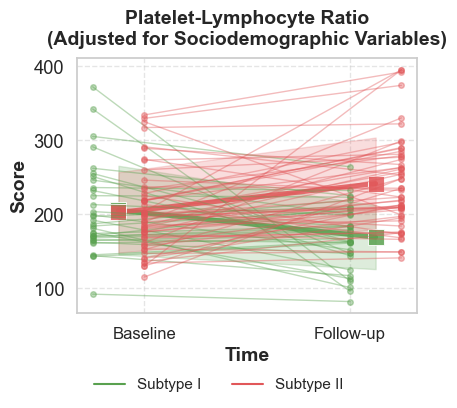

In [4]:
def plot_interaction(df_long, var_name):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # 设置整体风格，确保图表清晰且专业，增强图表对比度
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(4.5,4.5))  # 提高分辨率以满足高水平出版要求
    
    # 将群组标签映射到新的名称
    df_long['Cluster'] = df_long['Cluster'].map({0: 'Subtype I', 1: 'Subtype II'})
    
    # 使用具有色盲友好特性的调色板
    palette = {
        "Subtype I": "#59A14F",  # Green
        "Subtype II": "#E15759",  # Red
}
    # 绘制带误差条的交互作用图，并调整透明度以突出关键趋势线
    sns.lineplot(x="Time", y="Score", hue="Cluster", 
                 data=df_long, markers=True, dashes=False, 
                 ci='sd', palette=palette, 
                 marker='s', linewidth=3.5, alpha=0.85, markersize=12)
    
    # 为每个亚组设置不同的颜色，并在X轴上错开显示
    offset = {'Subtype I': -0.1, 'Subtype II': 0.1}  # 设置X轴偏移量
    for cluster, color in zip(['Subtype I', 'Subtype II'], ["#59A14F", "#E15759"]):
        grp = df_long[df_long['Cluster'] == cluster]
        for _, subject_grp in grp.groupby('Subject'):
            x_positions = subject_grp['Time'] + offset[cluster]  # 添加偏移量
            plt.plot(x_positions, subject_grp['Score'], marker='o', color=color, alpha=0.4, linewidth=1.0, markersize=4)

    # 图表标题和标签，使用更加清晰的字体大小和粗细
    plt.title(f'Platelet-Lymphocyte Ratio\n(Adjusted for Sociodemographic Variables)', fontsize=14, fontweight='bold', pad=10)

    plt.xlabel('Time', fontsize=14, fontweight='bold')
    plt.ylabel('Score', fontsize=14, fontweight='bold')
    plt.xticks([0.1, 0.9], ['Baseline', 'Follow-up'], fontsize=12)
    
    # 调整图例的位置和标签，设置图例框架和位置
    plt.legend(loc='upper left', fontsize=11, frameon=False, ncol=2, bbox_to_anchor=(0.01, -0.2))
    
    # 设置网格线，提升图表的专业感，适度降低透明度
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()  # 自动调整布局，确保图表元素不重叠
    plt.savefig(f'image/{var_name}.jpg', dpi=1200, bbox_inches='tight')
    plt.show()
# 调用示例：绘制指定变量的交互作用图
var_name = 'PIL_baseline'
plot_interaction(results[var_name]['df_long'], var_name)

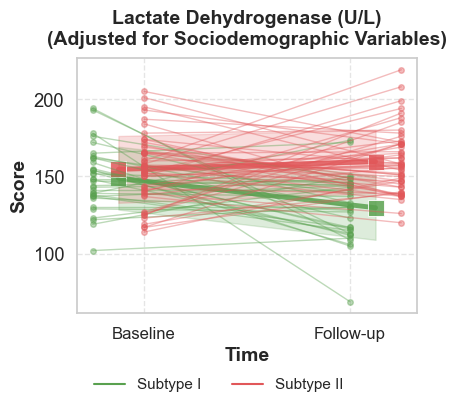

In [5]:
def plot_interaction(df_long, var_name):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # 设置整体风格，确保图表清晰且专业，增强图表对比度
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(4.5,4.5))  # 提高分辨率以满足高水平出版要求
    
    # 将群组标签映射到新的名称
    df_long['Cluster'] = df_long['Cluster'].map({0: 'Subtype I', 1: 'Subtype II'})
    
    # 使用具有色盲友好特性的调色板
    palette = {
        "Subtype I": "#59A14F",  # Green
        "Subtype II": "#E15759",  # Red
}
    # 绘制带误差条的交互作用图，并调整透明度以突出关键趋势线
    sns.lineplot(x="Time", y="Score", hue="Cluster", 
                 data=df_long, markers=True, dashes=False, 
                 ci='sd', palette=palette, 
                 marker='s', linewidth=3.5, alpha=0.85, markersize=12)
    
    # 为每个亚组设置不同的颜色，并在X轴上错开显示
    offset = {'Subtype I': -0.1, 'Subtype II': 0.1}  # 设置X轴偏移量
    for cluster, color in zip(['Subtype I', 'Subtype II'], ["#59A14F", "#E15759"]):
        grp = df_long[df_long['Cluster'] == cluster]
        for _, subject_grp in grp.groupby('Subject'):
            x_positions = subject_grp['Time'] + offset[cluster]  # 添加偏移量
            plt.plot(x_positions, subject_grp['Score'], marker='o', color=color, alpha=0.4, linewidth=1.0, markersize=4)

    # 图表标题和标签，使用更加清晰的字体大小和粗细
    plt.title(f'Lactate Dehydrogenase (U/L)\n(Adjusted for Sociodemographic Variables)', fontsize=14, fontweight='bold', pad=10)

    plt.xlabel('Time', fontsize=14, fontweight='bold')
    plt.ylabel('Score', fontsize=14, fontweight='bold')
    plt.xticks([0.1, 0.9], ['Baseline', 'Follow-up'], fontsize=12)
    
    # 调整图例的位置和标签，设置图例框架和位置
    plt.legend(loc='upper left', fontsize=11, frameon=False, ncol=2, bbox_to_anchor=(0.01, -0.2))
    
    # 设置网格线，提升图表的专业感，适度降低透明度
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()  # 自动调整布局，确保图表元素不重叠
    plt.savefig(f'image/{var_name}.jpg', dpi=1200, bbox_inches='tight')
    plt.show()
# 调用示例：绘制指定变量的交互作用图
var_name = 'LDH_baseline'
plot_interaction(results[var_name]['df_long'], var_name)

----

## 免疫

In [6]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')
# 读取数据
data = pd.read_excel('./rawdata.xlsx', sheet_name='Sheet2')

# 删除 'Cluster' 列中等于 3 的行
data_cleaned = data[data['Cluster'] != 3]


# 将列名中的空格替换为下划线,去掉逗号
data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 定义要检测的变量
variables = [
    ("CK_baseline", "CK_followup"),
    ("TG_baseline", "TG_followup"),
    ("CHOL_baseline", "CHOL_followup"),
    ("HDLC_baseline", "HDLC_followup"),
    ("LDLC_baseline", "LDLC_followup")
]

# 确保所有列名一致
required_columns = [
    'Cluster', 'Age', 
    'Education_years','Gender'
]

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行单因素协方差分析
def perform_ancova_analysis(symptom_var, time_point):
    # 选择特定时间点的数据
    if time_point == "baseline":
        df = data[[symptom_var] + required_columns]
    else:
        df = data[[symptom_var.replace("baseline", "followup")] + required_columns]
        df.columns = [col.replace("followup", "baseline") for col in df.columns]
    
    # 构建ANCOVA模型公式
    formula = (f"{symptom_var} ~ Cluster + Age + "
               "Education_years + " +
               " + ".join([col for col in required_columns if col != 'Cluster']))
    
    # 拟合模型
    model = ols(formula, data=df).fit()
    
    # 进行方差分析
    ancova_results = anova_lm(model, typ=2)
    
    # 对p值进行FDR BH校正
    p_values = ancova_results['PR(>F)'].values
    p_values_corrected = multipletests(p_values, method='fdr_bh')[1]
    ancova_results['PR(>F)_corrected'] = p_values_corrected
    
    # 返回结果
    return {
        'ANCOVA_summary': ancova_results,
        'Model_summary': model.summary()
    }

# 对每个变量在基线和随访时进行分析并存储结果
for baseline_var, followup_var in variables:
    # 基线分析
    results[baseline_var] = perform_ancova_analysis(baseline_var, "baseline")
    # 随访分析
    results[followup_var] = perform_ancova_analysis(baseline_var, "followup")

# 输出结果
for var, result in results.items():
    print(f"Variable: {var}")
    print(result['ANCOVA_summary'])
    print(result['Model_summary'])
    print("---")

Variable: CK_baseline
                        sum_sq    df         F    PR(>F)  PR(>F)_corrected
Cluster            4666.081535   1.0  1.128654  0.291220               NaN
Age                2452.347819   1.0  0.593186  0.443430               NaN
Education_years     115.923032   1.0  0.028040  0.867432               NaN
Gender               66.928749   1.0  0.016189  0.899069               NaN
Residual         334870.243015  81.0       NaN       NaN               NaN
                            OLS Regression Results                            
Dep. Variable:            CK_baseline   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.5450
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.703
Time:                        18:01:20   Log-Likelihood:                -477.52
No. Observations:                  86   AIC:          

In [7]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import warnings

warnings.filterwarnings('ignore')
# 读取数据
data = pd.read_excel('./rawdata.xlsx', sheet_name='Sheet2')

# 删除 'Cluster' 列中等于 3 的行
data_cleaned = data[data['Cluster'] != 3]

# 将列名中的空格替换为下划线,去掉逗号
data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 定义要检测的变量
variables = [
    ("CK_baseline", "CK_followup"),
    ("TG_baseline", "TG_followup"),
    ("CHOL_baseline", "CHOL_followup"),
    ("HDLC_baseline", "HDLC_followup"),
    ("LDLC_baseline", "LDLC_followup")
]

# 创建字典以存储结果
results = {}

# 定义函数进行配对t检验
def perform_paired_ttest(group, baseline_var, followup_var):
    baseline_scores = data[data['Cluster'] == group][baseline_var]
    followup_scores = data[data['Cluster'] == group][followup_var]
    
    # 进行配对t检验
    t_stat, p_value = stats.ttest_rel(baseline_scores, followup_scores)
    
    return p_value

# 对每个变量在两个亚组进行分析并存储结果
for baseline_var, followup_var in variables:
    p_values_group1 = perform_paired_ttest(0, baseline_var, followup_var)
    p_values_group2 = perform_paired_ttest(1, baseline_var, followup_var)
    
    # 将结果存储在字典中
    results[(baseline_var, 'Group1')] = p_values_group1
    results[(baseline_var, 'Group2')] = p_values_group2

# 将p值进行FDR BH校正
p_values = list(results.values())
p_values_corrected = multipletests(p_values, method='fdr_bh')[1]

# 更新结果字典
corrected_results = {}
for i, key in enumerate(results.keys()):
    corrected_results[key] = p_values_corrected[i]

# 输出结果
for var in variables:
    print(f"Variable: {var[0]}")
    print(f"Group 1 (Subtype I) p-value (corrected): {corrected_results[(var[0], 'Group1')]:.4f}")
    print(f"Group 2 (Subtype II) p-value (corrected): {corrected_results[(var[0], 'Group2')]:.4f}")
    print("---")

Variable: CK_baseline
Group 1 (Subtype I) p-value (corrected): 0.3624
Group 2 (Subtype II) p-value (corrected): 0.5237
---
Variable: TG_baseline
Group 1 (Subtype I) p-value (corrected): 0.6807
Group 2 (Subtype II) p-value (corrected): 0.3624
---
Variable: CHOL_baseline
Group 1 (Subtype I) p-value (corrected): 0.5237
Group 2 (Subtype II) p-value (corrected): 0.3624
---
Variable: HDLC_baseline
Group 1 (Subtype I) p-value (corrected): 0.2631
Group 2 (Subtype II) p-value (corrected): 0.8566
---
Variable: LDLC_baseline
Group 1 (Subtype I) p-value (corrected): 0.5237
Group 2 (Subtype II) p-value (corrected): 0.3624
---


## 代谢

In [8]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')
# 读取数据
data = pd.read_excel('./rawdata.xlsx', sheet_name='Sheet2')

# 删除 'Cluster' 列中等于 3 的行
data_cleaned = data[data['Cluster'] != 3]


# 将列名中的空格替换为下划线,去掉逗号
data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 定义要检测的变量
variables = [
    ( "WBC_baseline", "WBC_followup"),
    ("NEUT_baseline", "NEUT_followup"),
    ("LYMPH_baseline", "LYMPH_followup"),
    ("MONO_baseline", "MONO_followup"),
    ("PIL_baseline", "PIL_followup"),
    ("CRP_baseline", "CRP_followup"),
    ("NLR_baseline", "NLR_followup"),
    ("PLR_baseline", "PLR_followup"),
    ("MLR_baseline", "MLR_followup"),
    ("SIII_baseline", "SIII_followup"),
    ("ASTALT_baseline", "ASTALT_followup"),
    ("LDH_baseline", "LDH_followup"),
]

# 确保所有列名一致
required_columns = [
    'Cluster', 'Age', 
    'Education_years','Gender'
]

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行单因素协方差分析
def perform_ancova_analysis(symptom_var, time_point):
    # 选择特定时间点的数据
    if time_point == "baseline":
        df = data[[symptom_var] + required_columns]
    else:
        df = data[[symptom_var.replace("baseline", "followup")] + required_columns]
        df.columns = [col.replace("followup", "baseline") for col in df.columns]
    
    # 构建ANCOVA模型公式
    formula = (f"{symptom_var} ~ Cluster + Age + "
               "Education_years + " +
               " + ".join([col for col in required_columns if col != 'Cluster']))
    
    # 拟合模型
    model = ols(formula, data=df).fit()
    
    # 进行方差分析
    ancova_results = anova_lm(model, typ=2)
    
    # 对p值进行FDR BH校正
    p_values = ancova_results['PR(>F)'].values
    p_values_corrected = multipletests(p_values, method='fdr_bh')[1]
    ancova_results['PR(>F)_corrected'] = p_values_corrected
    
    # 返回结果
    return {
        'ANCOVA_summary': ancova_results,
        'Model_summary': model.summary()
    }

# 对每个变量在基线和随访时进行分析并存储结果
for baseline_var, followup_var in variables:
    # 基线分析
    results[baseline_var] = perform_ancova_analysis(baseline_var, "baseline")
    # 随访分析
    results[followup_var] = perform_ancova_analysis(baseline_var, "followup")

# 输出结果
for var, result in results.items():
    print(f"Variable: {var}")
    print(result['ANCOVA_summary'])
    print(result['Model_summary'])
    print("---")

Variable: WBC_baseline
                     sum_sq    df         F    PR(>F)  PR(>F)_corrected
Cluster            2.305548   1.0  1.041997  0.310397               NaN
Age                0.048864   1.0  0.022084  0.882232               NaN
Education_years    3.771044   1.0  1.704331  0.195419               NaN
Gender             0.546589   1.0  0.247032  0.620519               NaN
Residual         179.222573  81.0       NaN       NaN               NaN
                            OLS Regression Results                            
Dep. Variable:           WBC_baseline   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.5607
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.692
Time:                        18:01:20   Log-Likelihood:                -153.60
No. Observations:                  86   AIC:                           

In [9]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import warnings

warnings.filterwarnings('ignore')
# 读取数据
data = pd.read_excel('./rawdata.xlsx', sheet_name='Sheet2')

# 删除 'Cluster' 列中等于 3 的行
data_cleaned = data[data['Cluster'] != 3]

# 将列名中的空格替换为下划线,去掉逗号
data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 定义要检测的变量
variables = [
    ( "WBC_baseline", "WBC_followup"),
    ("NEUT_baseline", "NEUT_followup"),
    ("LYMPH_baseline", "LYMPH_followup"),
    ("MONO_baseline", "MONO_followup"),
    ("PIL_baseline", "PIL_followup"),
    ("CRP_baseline", "CRP_followup"),
    ("NLR_baseline", "NLR_followup"),
    ("PLR_baseline", "PLR_followup"),
    ("MLR_baseline", "MLR_followup"),
    ("SIII_baseline", "SIII_followup"),
    ("ASTALT_baseline", "ASTALT_followup"),
    ("LDH_baseline", "LDH_followup"),
]

# 创建字典以存储结果
results = {}

# 定义函数进行配对t检验
def perform_paired_ttest(group, baseline_var, followup_var):
    baseline_scores = data[data['Cluster'] == group][baseline_var]
    followup_scores = data[data['Cluster'] == group][followup_var]
    
    # 进行配对t检验
    t_stat, p_value = stats.ttest_rel(baseline_scores, followup_scores)
    
    return p_value

# 对每个变量在两个亚组进行分析并存储结果
for baseline_var, followup_var in variables:
    p_values_group1 = perform_paired_ttest(0, baseline_var, followup_var)
    p_values_group2 = perform_paired_ttest(1, baseline_var, followup_var)
    
    # 将结果存储在字典中
    results[(baseline_var, 'Group1')] = p_values_group1
    results[(baseline_var, 'Group2')] = p_values_group2

# 将p值进行FDR BH校正
p_values = list(results.values())
p_values_corrected = multipletests(p_values, method='fdr_bh')[1]

# 更新结果字典
corrected_results = {}
for i, key in enumerate(results.keys()):
    corrected_results[key] = p_values_corrected[i]

# 输出结果
for var in variables:
    print(f"Variable: {var[0]}")
    print(f"Group 1 (Subtype I) p-value (corrected): {corrected_results[(var[0], 'Group1')]:.4f}")
    print(f"Group 2 (Subtype II) p-value (corrected): {corrected_results[(var[0], 'Group2')]:.4f}")
    print("---")

Variable: WBC_baseline
Group 1 (Subtype I) p-value (corrected): 0.1780
Group 2 (Subtype II) p-value (corrected): 0.0482
---
Variable: NEUT_baseline
Group 1 (Subtype I) p-value (corrected): 0.7406
Group 2 (Subtype II) p-value (corrected): 0.0553
---
Variable: LYMPH_baseline
Group 1 (Subtype I) p-value (corrected): 0.0386
Group 2 (Subtype II) p-value (corrected): 0.9864
---
Variable: MONO_baseline
Group 1 (Subtype I) p-value (corrected): 0.7406
Group 2 (Subtype II) p-value (corrected): 0.9372
---
Variable: PIL_baseline
Group 1 (Subtype I) p-value (corrected): 0.0386
Group 2 (Subtype II) p-value (corrected): 0.0009
---
Variable: CRP_baseline
Group 1 (Subtype I) p-value (corrected): 0.8108
Group 2 (Subtype II) p-value (corrected): 0.6186
---
Variable: NLR_baseline
Group 1 (Subtype I) p-value (corrected): 0.0844
Group 2 (Subtype II) p-value (corrected): 0.8341
---
Variable: PLR_baseline
Group 1 (Subtype I) p-value (corrected): 0.4593
Group 2 (Subtype II) p-value (corrected): 0.1491
---
Vari

In [10]:
print('全部完成！')

全部完成！
